<a href="https://colab.research.google.com/github/imnawar/FaceDetection/blob/main/Face_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 7.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
!pip install GPUtil

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7394 sha256=f87bac569960b55cbb696e9ad94f9741e52cbd5e41cca329ffd4db185d7ea372
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil


In [ ]:
!pip install split-folders

In [ ]:
!pip install torchinfo

In [ ]:
import requests
from zipfile import ZipFile
from pathlib import Path

import os
import glob

import random as random
from PIL import Image

import torch
from torch import nn

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torchvision
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

from torchvision import datasets
from torchvision import transforms

import torchmetrics
import mlxtend

import matplotlib.pyplot as plt

from typing import Tuple
from typing import Dict
from typing import List
from timeit import default_timer as timer
from matplotlib import patches as mpatches

from tqdm.auto import tqdm

import gc

from numba import cuda

from GPUtil import showUtilization as gpu_usage

import splitfolders

from torchinfo import summary

import shutil

import numpy as np
import pandas as pd
import yaml

from os import listdir
from os.path import isfile, join

In [ ]:
def extract_data(zipfile_path: Path, destination_path: Path) -> None:
    '''Extracts zipfile'''

    if destination_path.is_dir():
        print(f"{destination_path} exists.")
    else:
        print(f"{destination_path} doesn't exist, creating one...")
        destination_path.mkdir(parents=True, exist_ok=True)

    if not os.listdir(destination_path):
        with ZipFile(zipfile_path, 'r') as zip:
            print("Extracting files...")
            zip.extractall(destination_path)

            print("Extracting finished.")
    else:
        print("Data already extracted.")

data_path = Path("/content")
zipfile_path = data_path / "emotions_archive.zip"
images_path = data_path / "emotions_dataset"

extract_data(zipfile_path, images_path)

/content/emotions_dataset doesn't exist, creating one...
Extracting files...
Extracting finished.


In [ ]:
# len(os.listdir('/content/emotions_dataset/train/sad'))

4830

In [ ]:
def walk_through_dir(dir_path: Path) -> None:
    """Prints dir_path content"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directiories and {len(filenames)} images in '{dirpath}' folder ")


walk_through_dir(images_path)

There are 2 directiories and 0 images in '/content/emotions_dataset' folder 
There are 7 directiories and 0 images in '/content/emotions_dataset/train' folder 
There are 0 directiories and 3995 images in '/content/emotions_dataset/train/angry' folder 
There are 0 directiories and 3171 images in '/content/emotions_dataset/train/surprised' folder 
There are 0 directiories and 4965 images in '/content/emotions_dataset/train/neutral' folder 
There are 0 directiories and 4097 images in '/content/emotions_dataset/train/fearful' folder 
There are 0 directiories and 7215 images in '/content/emotions_dataset/train/happy' folder 
There are 0 directiories and 436 images in '/content/emotions_dataset/train/disgusted' folder 
There are 0 directiories and 4830 images in '/content/emotions_dataset/train/sad' folder 
There are 7 directiories and 0 images in '/content/emotions_dataset/test' folder 
There are 0 directiories and 958 images in '/content/emotions_dataset/test/angry' folder 
There are 0 dir

Random image path: /content/emotions_dataset/train/angry/im2880.png
Random image class: angry
Image height: 48
Image width: 48


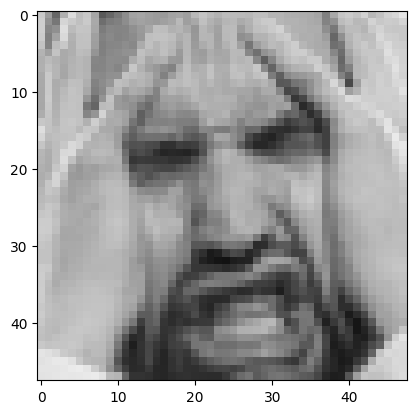

In [ ]:
%matplotlib inline

def print_random_image(images_path: list, seed=None) -> None:
    """Prints one random photo with details such as class, heigh, width"""
    if seed:
        random.seed(seed)

    random_image_path = random.choice(images_path)
    image_class = random_image_path.parent.stem
    image = Image.open(random_image_path)
    print(f"Random image path: {random_image_path}")
    print(f"Random image class: {image_class}")
    print(f"Image height: {image.height}")
    print(f"Image width: {image.width}")
    plt.imshow(image.convert('P'))


image_path_list = list(images_path.glob("*/*/*"))
print_random_image(image_path_list)

In [ ]:
train_transform = transforms.Compose(
    [transforms.Resize(size=(224, 224)),
     transforms.ToTensor()]
)

val_transform = transforms.Compose(
    [transforms.Resize(size=(224, 224)),
     transforms.ToTensor()]
)

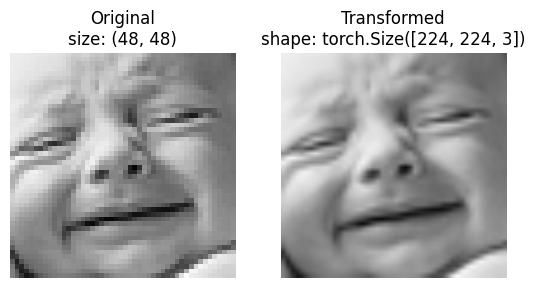

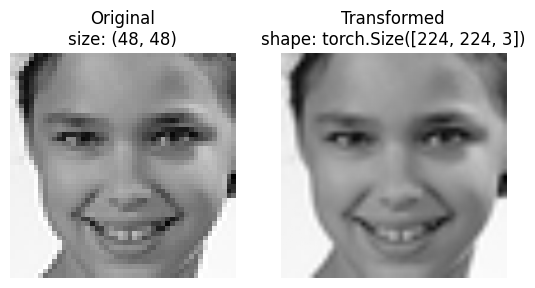

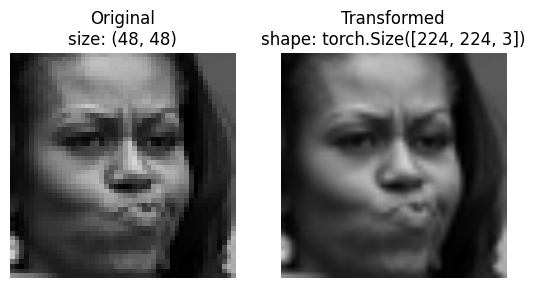

In [ ]:
def plot_transformed_images(images_path: Path,
                            transform: transforms,
                            n: int=3,
                            seed=None) -> None:
    """Selects random images from a path, transforms them and plots original vs transform"""
    if seed:
        random.seed(seed)

    if n > 10:
        print("n shouldn't be higher than 10 due to the size of displayed plot, changing n to 10")
        n = 10

    random_image_paths = random.sample(images_path, k=n)

    for image_path in random_image_paths:
        with Image.open(image_path).convert('RGB') as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nsize: {f.size}")
            ax[0].axis(False)

            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nshape: {transformed_image.shape}")
            ax[1].axis(False)


plot_transformed_images(image_path_list, train_transform)

In [ ]:
train_dir = images_path / "train"
val_dir = images_path / "test"

train_data = datasets.ImageFolder(
    root=train_dir,
    transform=train_transform
)

val_data = datasets.ImageFolder(
    root=val_dir,
    transform=val_transform
)

In [ ]:
BATCH_SIZE = 8

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)

val_dataloader = DataLoader(
    dataset=val_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4
)

image_batch, label_batch = next(iter(train_dataloader))
image_batch.shape, label_batch.shape

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(torch.Size([8, 3, 224, 224]), torch.Size([8]))

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
BATCH_SIZE = 16
model = torchvision.models.efficientnet_b0().to(device)

summary(
    model=model,
    input_size=(BATCH_SIZE, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [16, 3, 224, 224]    [16, 1000]           --                   True
├─Sequential (features)                                      [16, 3, 224, 224]    [16, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [16, 3, 224, 224]    [16, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [16, 3, 224, 224]    [16, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [16, 32, 112, 112]   [16, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [16, 32, 112, 112]   [16, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [16, 32, 112, 112]   [16, 16, 112

In [ ]:
output_shape = len(train_data.classes)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

summary(
    model=model,
    input_size=(BATCH_SIZE, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [16, 3, 224, 224]    [16, 7]              --                   True
├─Sequential (features)                                      [16, 3, 224, 224]    [16, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [16, 3, 224, 224]    [16, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [16, 3, 224, 224]    [16, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [16, 32, 112, 112]   [16, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [16, 32, 112, 112]   [16, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [16, 32, 112, 112]   [16, 16, 112

In [ ]:
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device) -> Tuple[float, float]:

    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(y_pred, dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc


def val_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device: torch.device) -> Tuple[float, float, torch.Tensor]:

    model.eval()
    val_loss, val_acc = 0, 0
    y_preds = []

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            val_pred_logits = model(X)
            loss = loss_fn(val_pred_logits, y)
            val_loss += loss.item()

            val_pred_labels = torch.argmax(val_pred_logits, dim=1)
            val_acc += ((val_pred_labels == y).sum().item() / len(val_pred_labels))
            y_preds.append(val_pred_labels.cpu())

    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)

    y_pred_tensor = torch.cat(y_preds)

    return val_loss, val_acc, y_pred_tensor


def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    val_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: torch.device) -> Tuple[Dict, torch.Tensor]:

    results = {"train_loss": [],
             "train_acc": [],
             "val_loss": [],
             "val_acc": []}

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device
        )

        val_loss, val_acc, y_preds = val_step(
            model=model,
            dataloader=val_dataloader,
            loss_fn=loss_fn,
            device=device
        )

        print(f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Train acc: {train_acc:.3f}, Val loss: {val_loss:.3f}, Val acc: {val_acc:.3f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

    return results, y_preds

In [ ]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)

EPOCHS = 10

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(
    params=model.parameters(),
    lr=0.01
)

start_time = timer()

model_results, preds = train(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=EPOCHS,
    device=device
)

end_time = timer()
print(f"Total learning time: {(end_time - start_time):.3f}")

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
def plot_curves(results: Dict[str, List[float]]) -> None:
    """Plots loss and accuracy from a results dictionary."""

    train_loss = results["train_loss"]
    val_loss = results["val_loss"]

    train_accuracy = results["train_acc"]
    val_accuracy = results["val_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="train_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label="train_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


plot_curves(model_results)

In [ ]:
def draw_confusion_matrix(data: datasets.ImageFolder,
                          preds: torch.Tensor) -> None:

    confmat = ConfusionMatrix(num_classes=len(data.classes))
    confmat_tensor = confmat(
        preds=preds,
        target=torch.ShortTensor(val_data.targets)
    )

    fig, ax = plot_confusion_matrix(
        conf_mat=confmat_tensor.numpy(),
        class_names=data.classes,
        figsize=(10, 7))


draw_confusion_matrix(data=val_data,
                      preds=preds)

In [ ]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device) -> torch.Tensor:

    pred_probs = []
    model.eval()

    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)


def show_predictions(model: torch.nn.Module,
                     device: torch.device,
                     val_data: datasets) -> None:

    val_samples = []
    val_labels = []

    for sample, label in random.sample(list(val_data), k=9):
        val_samples.append(sample)
        val_labels.append(label)

    pred_probs = make_predictions(
        model=model,
        data=val_samples,
        device=device
    )

    pred_classes = pred_probs.argmax(dim=1)
    plt.figure(figsize=(9, 9))
    nrows = 3
    ncols = 3

    for i, sample in enumerate(val_samples):
        plt.subplot(nrows, ncols, i+1)
        image = sample.squeeze().permute(1, 2, 0)
        plt.imshow(image)
        pred_label = val_data.classes[pred_classes[i]]
        truth_label = val_data.classes[val_labels[i]]
        title_text = f"Pred: {pred_label} | Truth: {truth_label}"

        if pred_label == truth_label:
            plt.title(title_text, fontsize=10, c="g")
        else:
            plt.title(title_text, fontsize=10, c="r")
        plt.axis(False)


show_predictions(
    model=model,
    val_data=val_data,
    device=device)